In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from vae import VAE, Encoder, Decoder, DATA_DIM, MAX_SEQ_LEN, PITCH_DIM

demo_load_path = 'datasets/Demo_64_conditioned.npy'
start_samples = np.load(demo_load_path)
# start_samples = np.array(np.round(samples, decimals=0), dtype=int)
start_samples = np.array(start_samples, dtype=float) # / 127.
start_samples = np.squeeze(start_samples)

In [23]:
start_samples

array([[[  0.,   0.,   0., ...,   0., 127.,   0.],
        [  0.,   0.,   0., ...,   0., 127.,   0.],
        [  0.,   0.,   0., ...,   0., 127.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       ...,

       [[  0.,   0.,   0

In [24]:
start_samples.shape

(12, 128, 90)

Text(0.5, 1.0, 'Training data')

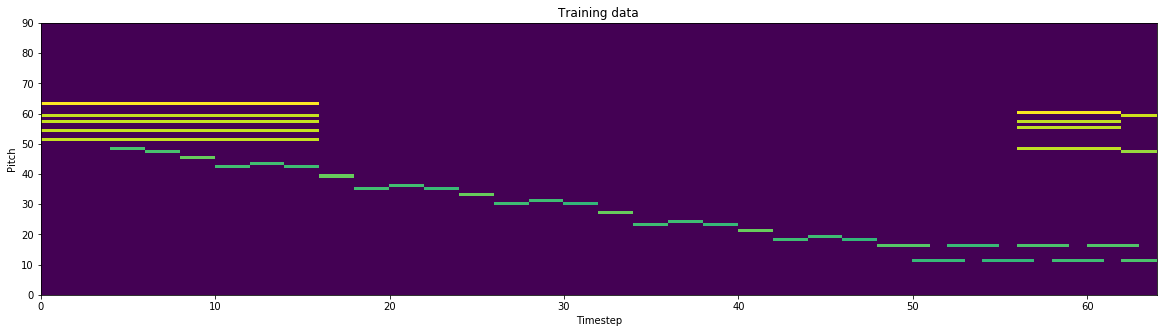

In [27]:
sample = np.vstack(start_samples[8:][:,64:])

sample0 = start_samples[0,64:] # Chopin
sample1 = start_samples[4,64:] # Turkey
sample2 = start_samples[8,64:] # Elise
zero0 =  np.zeros_like(sample0)
start0 = np.concatenate([np.zeros([MAX_SEQ_LEN, 88]), np.ones([MAX_SEQ_LEN, 1]), np.zeros([MAX_SEQ_LEN, 1])], axis=-1)
start_seqs = np.stack([sample0, sample1, sample2, zero0, start0])
# start_seqs = np.stack([zero0] * 10)

plt.pcolor(sample0.T)
plt.xlabel("Timestep")
plt.ylabel("Pitch")
plt.title("Training data")

In [50]:
def sample_vae_with_start(vae, start_seqs):
    x = torch.zeros([1, DATA_DIM], dtype=torch.float)

    if vae.use_cuda:
        x = x.cuda()
#         cond = cond.cuda()

    samples_cond = []
    for start_seq in start_seqs:
        samples = []
        samples.append(start_seq * 127.)
        cond = torch.tensor(start_seq, dtype=torch.float).view(1, DATA_DIM)
        if vae.use_cuda:
            cond = cond.cuda()
        
        for rr in range(10):
            # get loc from the model
            sample_loc_i = vae.model(x, cond)
            cond = sample_loc_i * 127.
            sampled_data = sample_loc_i[0].view(MAX_SEQ_LEN, PITCH_DIM).cpu().data.numpy() * 127.
            samples.append(sampled_data)
            if vae.use_cuda:
                cond = cond.cuda()
        
        samples = np.stack(samples)
        samples_cond.append(samples)
        
    samples_cond = np.stack(samples_cond)
    
    return samples_cond


# def sample_vae(vae, cuda):
#     x = torch.zeros([1, DATA_DIM])
#     # start = torch.cat(torch.zeros([1, MAX_SEQ_LEN, 88]) + torch.ones([1, MAX_SEQ_LEN, 1]) + torch.zeros([1, MAX_SEQ_LEN, 1]), dim=-1)
#     start = torch.cat([torch.zeros(1, MAX_SEQ_LEN, 88), torch.ones(1, MAX_SEQ_LEN, 1), torch.zeros(1, MAX_SEQ_LEN, 1)], dim=-1)    

#     if cuda:
#         x = x.cuda()

#     total_samples = []
#     for i in range(10):
#         samples = []
#         cond = start.reshape(-1, MAX_SEQ_LEN * PITCH_DIM).cuda()
#         for rr in range(20):
#             # get loc from the model
#             sample_loc_i = vae.model(x, cond)
#             cond = sample_loc_i * MAX_VEL
#             sampled_data = sample_loc_i[0].view(1, MAX_SEQ_LEN, PITCH_DIM).cpu().data.numpy() * MAX_VEL
#             samples.append(sampled_data)
#         total_samples.append(samples)
    
#     return total_samples

In [51]:
def velmapping(x, xmin = 60, xmax = 127., ymin=0, ymax=127):
    y = (x - xmin).clip(0) / (xmax - xmin) * (ymax - ymin) + ymin
    return y

In [52]:
vae = torch.load("outputs/MAESTRO_64_VAE_num_particle_16/best_model.pt")
sample = sample_vae_with_start(vae, start_seqs/127)
sample = sample[:,:,:,:88]
sample = velmapping(sample*127)

Text(0.5, 1.0, 'Generated Sample')

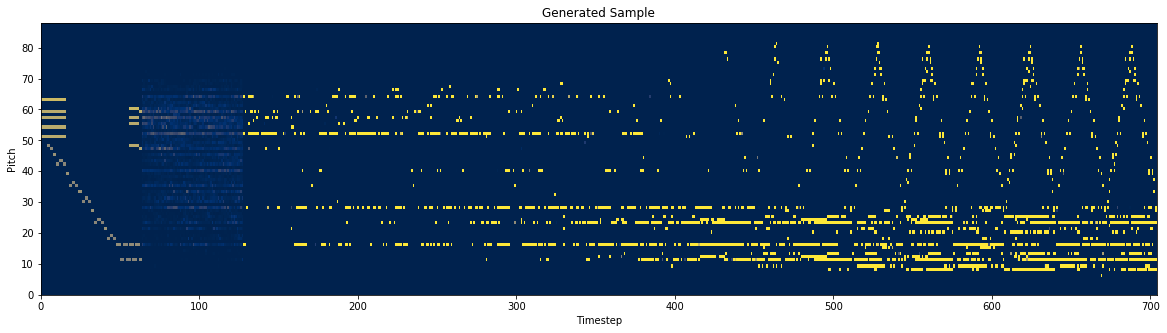

In [53]:
# generated = velmapping(np.vstack(sample[0]))
generated = np.vstack(sample[0])
plt.rcParams['figure.figsize'] = [20, 5]
plt.pcolor(generated.T, cmap='cividis')
plt.xlabel("Timestep")
plt.ylabel("Pitch")
plt.title("Generated Sample")

In [54]:
generated_sample_save = np.vstack(sample)

In [527]:
np.save("generated_start_iwae", generated_sample_save)

Text(0.5, 1.0, 'Training data')

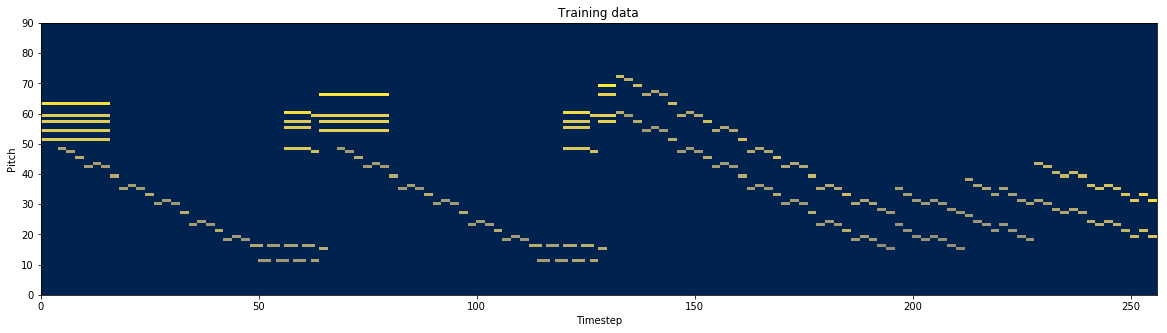

In [526]:
datasample0 = np.vstack(start_samples[0:4,64:]) # Chopin
datasample1 = np.vstack(start_samples[4:8,64:]) # Turkey
datasample2 = np.vstack(start_samples[8:,64:]) # Elise

plt.pcolor(datasample0.T, cmap='cividis')
plt.xlabel("Timestep")
plt.ylabel("Pitch")
plt.title("Training data")

In [461]:
training_data = np.vstack(start_samples)

In [482]:
np.save("training", start_samples)

In [474]:
from midi_extractor.write_midi import write_midi

In [531]:
def np_to_midi(name, tpb=4, tmp=80):
    prs = np.load(name + '.npy', allow_pickle=True)
    
    prs = np.array(np.round(prs, decimals=0), dtype=int)
    prs = np.squeeze(prs)
    prs = (prs / prs.max()) * 97
    print(prs.shape)
    prs = np.array(prs // (128//16) * (128//16))
    prs = prs[:,:,:,:88]
    prs = np.vstack(prs)
    # pr = prs[0]
    # pr : [sequence_len, pitch_dim] :0~127
    # pr = np.vstack(prs[:,:5])

    pr_dict = {"piano" : np.squeeze(prs)}

    write_midi(pr_dict, tpb, name + ".mid", tempo=tmp)

In [533]:
np_to_midi('outputs/MAESTRO_64_VAE_num_particle_8/generated_samples')

(10, 20, 64, 90)


83272

83272